In [1]:
from Neuron_analysis_tool.load import Analyzer, long_pulse_protocol
from neuron import gui, h
import numpy as np
import os
import matplotlib.pyplot as plt

NEURON: unable to open font "*helvetica-medium-r-normal*--14*", using "fixed"


In [2]:

def Rin_func(seg):
    imp = h.Impedance(seg.x, sec=seg.sec)
    imp.loc(seg.x, sec=seg.sec)
    imp.compute(0, 1)
    return imp.input(seg.x, sec=seg.sec)


In [3]:
analyser = Analyzer(type='L5PC')

optimizing lines: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 122206.57it/s]


(<Figure size 1200x300 with 4 Axes>,
 array([<AxesSubplot:title={'center':'morphology'}>,
        <AxesSubplot:title={'center':'d3_2 dendogram'}>,
        <AxesSubplot:title={'center':'long pulse attanuation'}>,
        <AxesSubplot:title={'center':'short pulse attanuation'}>],
       dtype=object))

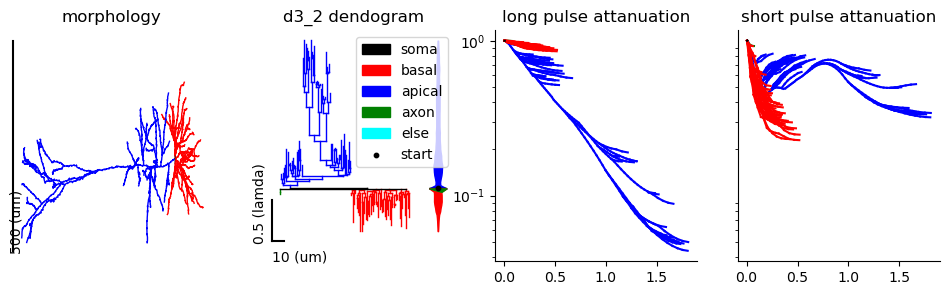

In [4]:
analyser.create_card(theta=0)

optimizing lines: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 113032.25it/s]


(<Figure size 1200x300 with 4 Axes>,
 array([<AxesSubplot:title={'center':'morphology'}>,
        <AxesSubplot:title={'center':'d3_2 dendogram'}>,
        <AxesSubplot:title={'center':'long pulse attanuation'}>,
        <AxesSubplot:title={'center':'short pulse attanuation'}>],
       dtype=object))

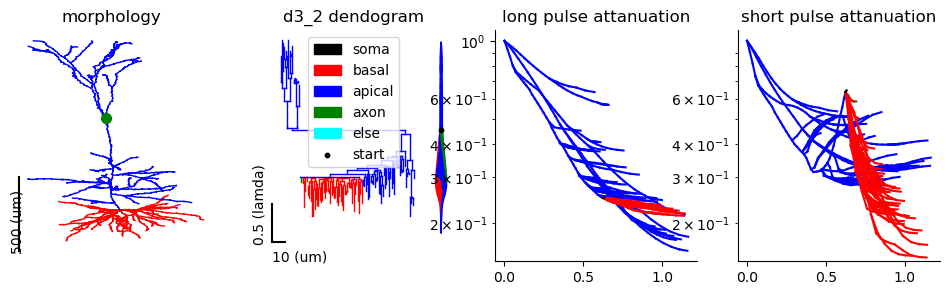

In [6]:
analyser.create_card(initial_seg=list(analyser.cell.apic[50])[-1], theta=-90)

In [12]:
[(j, i) for i in analyser.cell.apic[10] for j in i]

[(ca_ion, L5PCtemplate[0].apic[10](0.1)),
 (CaDynamics_E2, L5PCtemplate[0].apic[10](0.1)),
 (k_ion, L5PCtemplate[0].apic[10](0.1)),
 (Im, L5PCtemplate[0].apic[10](0.1)),
 (na_ion, L5PCtemplate[0].apic[10](0.1)),
 (NaTa_t, L5PCtemplate[0].apic[10](0.1)),
 (SKv3_1, L5PCtemplate[0].apic[10](0.1)),
 (Ca_HVA, L5PCtemplate[0].apic[10](0.1)),
 (Ca_LVAst, L5PCtemplate[0].apic[10](0.1)),
 (SK_E2, L5PCtemplate[0].apic[10](0.1)),
 (Ih, L5PCtemplate[0].apic[10](0.1)),
 (pas, L5PCtemplate[0].apic[10](0.1)),
 (ca_ion, L5PCtemplate[0].apic[10](0.3)),
 (CaDynamics_E2, L5PCtemplate[0].apic[10](0.3)),
 (k_ion, L5PCtemplate[0].apic[10](0.3)),
 (Im, L5PCtemplate[0].apic[10](0.3)),
 (na_ion, L5PCtemplate[0].apic[10](0.3)),
 (NaTa_t, L5PCtemplate[0].apic[10](0.3)),
 (SKv3_1, L5PCtemplate[0].apic[10](0.3)),
 (Ca_HVA, L5PCtemplate[0].apic[10](0.3)),
 (Ca_LVAst, L5PCtemplate[0].apic[10](0.3)),
 (SK_E2, L5PCtemplate[0].apic[10](0.3)),
 (Ih, L5PCtemplate[0].apic[10](0.3)),
 (pas, L5PCtemplate[0].apic[10](0.3)),


In [19]:
list(analyser.cell.apic[10])[-1].gCa_LVAst_Ca_LVAst

1.10343262325055e-10

optimizing lines: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 122955.97it/s]


(<AxesSubplot:title={'center':'Rin with color code'}>,
 <matplotlib.colorbar.ColorbarBase at 0x7efcaf414a60>)

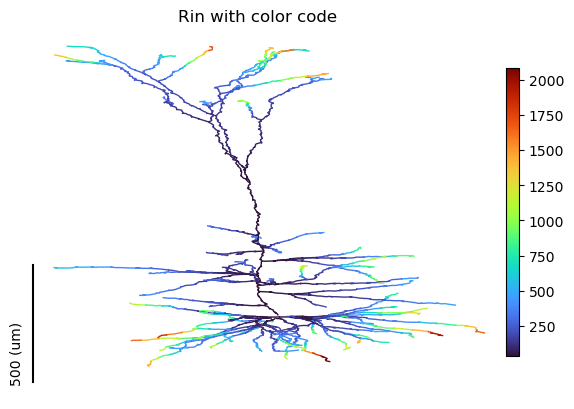

In [7]:
plt.title('Rin with color code')
analyser.plot_morph_with_value_func(func = Rin_func, run_time=1000, theta=-90, scale=500)


optimizing lines: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 111032.36it/s]


Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


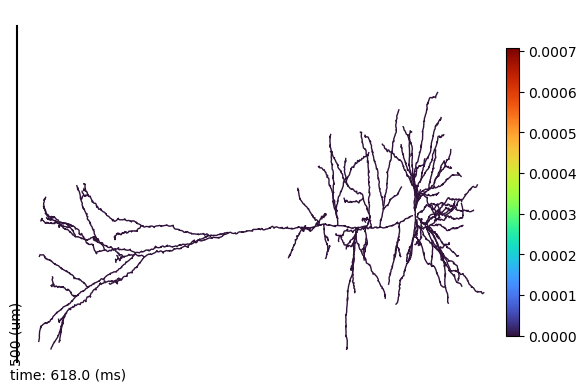

In [5]:
record_dict, time = analyser.record_protocol(cut_start_ms=1000.0, record_name='gCa_LVAst_Ca_LVAst')
animation = analyser.create_movie_from_rec(record_dict=record_dict, time=time, fps=10, clip_name='L5PC_gCa_spikes', threads=4, slow_down_factor=50, func_for_missing_frames=np.max, theta=-90)
animation.ipython_display(fps=10, loop=True, autoplay=True)

optimizing lines: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 117743.28it/s]


Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


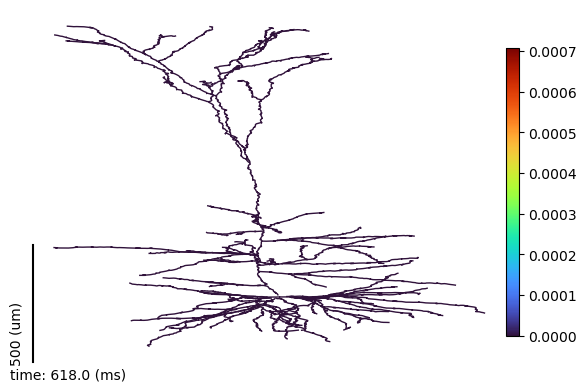

In [6]:
record_dict, time = analyser.record_protocol(cut_start_ms=1000.0, record_name='gCa_LVAst_Ca_LVAst')
animation = analyser.create_movie_from_rec(record_dict=record_dict, time=time, fps=10, clip_name='L5PC_gCa_spikes', threads=4, slow_down_factor=50, func_for_missing_frames=np.max, theta=-90)
animation.ipython_display(fps=10, loop=True, autoplay=True)

optimizing lines: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 39978.78it/s]


Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


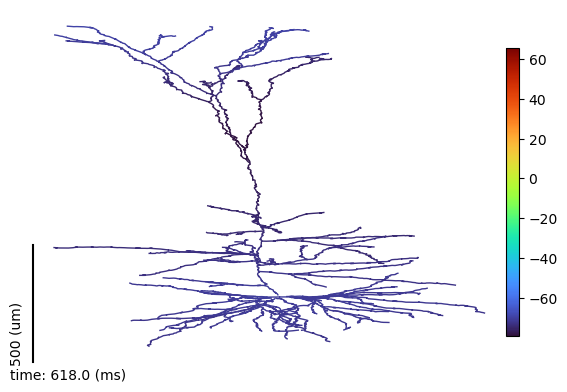

In [4]:
record_dict, time = analyser.record_protocol(cut_start_ms=1000.0, record_name='v')
animation = analyser.create_movie_from_rec(record_dict=record_dict, time=time, fps=10, clip_name='L5PC_V_spikes', threads=4, slow_down_factor=50, func_for_missing_frames=np.max, theta=-90)
animation.ipython_display(fps=10, loop=True, autoplay=True)